In [1]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 760 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [2]:
gen = image.ImageDataGenerator()

In [3]:
batches = gen.flow_from_directory(path+'/image_contest_level_1', 
                                  batch_size=1, 
                                  target_size=(30,90),
                                  shuffle=False,
                                  class_mode=None,
                                  color_mode='grayscale'
                                 )

Found 100000 images belonging to 1 classes.


In [5]:
imgs = np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [35]:
save_array(path+'imgs.dat', path)

In [ ]:
imgs = load_array(path+'imgs.dat')

In [6]:
x2label_idx = [int(f[8:][:-4]) for f in batches.filenames]

In [7]:
x2label_idx[:10]

[81314, 42703, 94273, 72552, 17141, 50750, 48773, 94926, 47470, 13306]

In [8]:
label_texts = []
lines = []
with open(path+'labels.txt') as f:
    lines = f.readlines()
label_texts = [l.strip().split()[0] for l in lines]

In [9]:
label_texts[:10]

['(4*8)+8',
 '7+3*0',
 '5+(5+2)',
 '(8-0)-8',
 '0+(0+2)',
 '(2*5)+0',
 '0+(1+8)',
 '2+(4+9)',
 '7*2+4',
 '0-(7*1)']

In [10]:
tokens = ['0','1','2', '3','4','5','6','7','8','9', 
          '+', '-', '*',
         '(0', '(1', '(2', '(3', '(4', '(5', '(6', '(7', '(8', '(9',
         '0)', '1)', '2)', '3)', '4)', '5)', '6)', '7)', '8)', '9)']

In [11]:
len(tokens)

33

In [13]:
token2idx={char:i for i, char in enumerate(tokens)}

In [14]:
labels = []
for ts in label_texts:
    cursor = 0
    l = []
    while cursor < len(ts):
        c = ts[cursor]
        if c == '(':
            l.append(token2idx[c + ts[cursor+1]])
            cursor = cursor + 2
        elif cursor+1 < len(ts) and ts[cursor+1] == ')':
            l.append(token2idx[c + ts[cursor+1]])
            cursor = cursor + 2
        else:
            l.append(token2idx[c])
            cursor = cursor + 1

    labels.append(l)
labels = np.array(labels)

In [16]:
token_size, seq_len = len(tokens), len(labels[0])
token_size, seq_len

(33, 5)

In [17]:
labels.shape

(100000, 5)

In [18]:
idxs = np.random.permutation(imgs.shape[0])
mask = np.random.rand(len(imgs)) < 0.8
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]

In [19]:
len(trn_idxs), len(val_idxs)

(80044, 19956)

In [20]:
x_trn = imgs[trn_idxs]
y_trn_m = labels[np.array(x2label_idx)[trn_idxs]]

y_trn = np.expand_dims(np.stack(y_trn_m, axis=0), -1)

In [21]:
x_trn.shape, y_trn.shape

((80044, 1, 30, 90), (80044, 5, 1))

In [22]:
y_trn.shape

(80044, 5, 1)

In [23]:
x_val = imgs[val_idxs]
y_val_m = labels[np.array(x2label_idx)[val_idxs]]
y_val = np.expand_dims(np.stack(y_val_m, axis=0), -1)

In [24]:
x_val.shape, y_val.shape

((19956, 1, 30, 90), (19956, 5, 1))

In [24]:
np.array(label_texts)[np.array(x2label_idx)[[0]]]

array(['1+4+8NN'], 
      dtype='|S7')

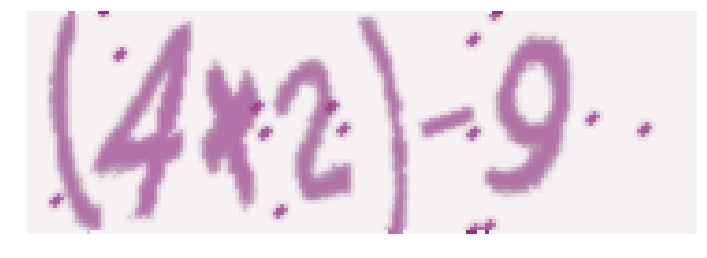

In [57]:
plots([image.load_img(path + 'image_contest_level_1/'+batches.filenames[13419])], titles=None)

In [58]:
val_idxs[0]

'1-(8+4)'

In [25]:
mean_px = x_trn.mean().astype(np.float32)
std_px = x_trn.std().astype(np.float32)

In [26]:
def norm_input(x): return (x-mean_px)/std_px

# Single dense layer

In [117]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,60,180)),
    Flatten(),
    Dense(70, activation='relu'),
    Reshape((7, 10)),
    TimeDistributed(Dense(17, activation='softmax'))
])

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_15 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 60, 180)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [118]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_15 (Lambda)               (None, 1, 60, 180)    0           lambda_input_14[0][0]            
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 10800)         0           lambda_15[0][0]                  
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 70)            756070      flatten_15[0][0]                 
____________________________________________________________________________________________________
reshape_10 (Reshape)             (None, 7, 10)         0           dense_32[0][0]                   
___________________________________________________________________________________________

In [133]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [140]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))

Train on 7939 samples, validate on 2061 samples
Epoch 1/1
7939/7939 [==============================] - 1s - loss: 0.9430 - acc: 0.6604 - val_loss: 1.0708 - val_acc: 0.6259


# Basic Vgg style 

In [141]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,30,90)),
    Convolution2D(32,3,3, activation='relu'),
    Convolution2D(32,3,3, activation='relu'),
    MaxPooling2D(),
    Convolution2D(64,3,3, activation='relu'),
    Convolution2D(64,3,3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(seq_len*10, activation='relu'),
    Reshape((seq_len, 10)),
    TimeDistributed(Dense(token_size, activation='softmax'))
])

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_16 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 60, 180)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [142]:
model.compile(Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [143]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=2, validation_data=(x_val, y_val))

Train on 7939 samples, validate on 2061 samples
Epoch 1/2
7939/7939 [==============================] - 28s - loss: 1.7933 - acc: 0.3787 - val_loss: 1.4461 - val_acc: 0.5168
Epoch 2/2
7939/7939 [==============================] - 28s - loss: 1.2494 - acc: 0.5891 - val_loss: 1.1649 - val_acc: 0.6127


In [144]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=2, validation_data=(x_val, y_val))

Train on 7939 samples, validate on 2061 samples
Epoch 1/2
7939/7939 [==============================] - 28s - loss: 1.0651 - acc: 0.6478 - val_loss: 1.0614 - val_acc: 0.6546
Epoch 2/2
7939/7939 [==============================] - 28s - loss: 0.9381 - acc: 0.6866 - val_loss: 0.9928 - val_acc: 0.6744


In [145]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=2, validation_data=(x_val, y_val))

Train on 7939 samples, validate on 2061 samples
Epoch 1/2
7939/7939 [==============================] - 28s - loss: 0.8705 - acc: 0.7040 - val_loss: 0.9370 - val_acc: 0.6873
Epoch 2/2
7939/7939 [==============================] - 28s - loss: 0.8052 - acc: 0.7193 - val_loss: 0.9007 - val_acc: 0.6938


# Batchnorm

In [38]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,30,90)),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    
    Flatten(),
    BatchNormalization(),
    Dense(seq_len*20, activation='relu'),
    BatchNormalization(),
    Reshape((seq_len, 20)),
    TimeDistributed(Dense(token_size, activation='softmax'))
])

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 30, 90)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [57]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 1, 30, 90)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 28, 88)    320         lambda_1[0][0]                   
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 28, 88)    128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 26, 86)    9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [39]:
model.compile(Adam(lr=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=2, validation_data=(x_val, y_val))

Train on 80044 samples, validate on 19956 samples
Epoch 1/2
80044/80044 [==============================] - 90s - loss: 0.1720 - acc: 0.9423 - val_loss: 0.2768 - val_acc: 0.9298
Epoch 2/2
80044/80044 [==============================] - 90s - loss: 0.0573 - acc: 0.9862 - val_loss: 0.5573 - val_acc: 0.9245


In [35]:
model.predict(x_val[:1]).shape

(1, 7, 17)

In [54]:
def predict(x):
    ps = model.predict(x)
    print([''.join([tokens[np.argmax(i)] for i in p]) for p in ps])

In [63]:
predict(x_val[:1])

['(4+2)-9']


In [50]:
tokens

'5-5*1NN'

In [80]:
model.optimizer.lr=0.01

In [81]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, validation_data=(x_val, y_val))

Train on 79860 samples, validate on 20140 samples
Epoch 1/1
79860/79860 [==============================] - 91s - loss: 0.0753 - acc: 0.9889 - val_loss: 0.2449 - val_acc: 0.9757


In [ ]:
model.optimizer.lr=0.001

In [38]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.0413 - acc: 0.9878 - val_loss: 1.5496 - val_acc: 0.8078
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.0438 - acc: 0.9870 - val_loss: 0.1985 - val_acc: 0.9568
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.0343 - acc: 0.9897 - val_loss: 0.2150 - val_acc: 0.9503
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.0300 - acc: 0.9909 - val_loss: 0.5148 - val_acc: 0.9139


# dropout

In [38]:
model = Sequential([
    Lambda(norm_input, input_shape=(1,30,90)),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(32,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    Convolution2D(64,3,3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Reshape((7, 100)),
    TimeDistributed(Dense(17, activation='softmax'))
])

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 30, 90)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [40]:
model.compile(Adam(lr=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 1, 30, 90)     0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 32, 28, 88)    320         lambda_4[0][0]                   
____________________________________________________________________________________________________
batchnormalization_19 (BatchNorm (None, 32, 28, 88)    128         convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 32, 26, 86)    9248        batchnormalization_19[0][0]      
___________________________________________________________________________________________

In [42]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 79839 samples, validate on 20161 samples
Epoch 1/4
79839/79839 [==============================] - 94s - loss: 0.7562 - acc: 0.8354 - val_loss: 2.5885 - val_acc: 0.8192
Epoch 2/4
79839/79839 [==============================] - 94s - loss: 1.7542 - acc: 0.8816 - val_loss: 5.8716 - val_acc: 0.6307
Epoch 3/4
79839/79839 [==============================] - 94s - loss: 1.9176 - acc: 0.8775 - val_loss: 11.6499 - val_acc: 0.2765
Epoch 4/4
79839/79839 [==============================] - 94s - loss: 2.0450 - acc: 0.8707 - val_loss: 14.3950 - val_acc: 0.1068


In [29]:
model.optimizer.lr=0.01

In [30]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 79839 samples, validate on 20161 samples
Epoch 1/4
79839/79839 [==============================] - 89s - loss: 0.3963 - acc: 0.8363 - val_loss: 0.8403 - val_acc: 0.8315
Epoch 2/4
79839/79839 [==============================] - 89s - loss: 0.3875 - acc: 0.8404 - val_loss: 3.3851 - val_acc: 0.6475 1s - loss: 0.38
Epoch 3/4
79839/79839 [==============================] - 89s - loss: 0.3835 - acc: 0.8417 - val_loss: 6.5607 - val_acc: 0.4533
Epoch 4/4
79839/79839 [==============================] - 89s - loss: 0.3713 - acc: 0.8450 - val_loss: 2.1141 - val_acc: 0.8101


In [31]:
model.optimizer.lr=0.001
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 79839 samples, validate on 20161 samples
Epoch 1/4
79839/79839 [==============================] - 89s - loss: 0.3769 - acc: 0.8441 - val_loss: 2.9895 - val_acc: 0.6867
Epoch 2/4
79839/79839 [==============================] - 89s - loss: 0.3579 - acc: 0.8507 - val_loss: 3.0588 - val_acc: 0.6825
Epoch 3/4
79839/79839 [==============================] - 89s - loss: 0.3675 - acc: 0.8478 - val_loss: 5.7585 - val_acc: 0.5478
Epoch 4/4
79839/79839 [==============================] - 89s - loss: 0.3513 - acc: 0.8528 - val_loss: 2.4509 - val_acc: 0.6909


In [56]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.5158 - acc: 0.7775 - val_loss: 0.1391 - val_acc: 0.9531
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.5123 - acc: 0.7785 - val_loss: 0.1634 - val_acc: 0.9352
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.5007 - acc: 0.7837 - val_loss: 0.1569 - val_acc: 0.9380
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.4903 - acc: 0.7907 - val_loss: 0.1245 - val_acc: 0.9543


In [57]:
model.fit(x_trn, y_trn, batch_size=64, nb_epoch=4, validation_data=(x_val, y_val))

Train on 8038 samples, validate on 1962 samples
Epoch 1/4
8038/8038 [==============================] - 9s - loss: 0.4862 - acc: 0.7901 - val_loss: 0.2018 - val_acc: 0.9251
Epoch 2/4
8038/8038 [==============================] - 9s - loss: 0.4848 - acc: 0.7899 - val_loss: 0.1457 - val_acc: 0.9459
Epoch 3/4
8038/8038 [==============================] - 9s - loss: 0.4692 - acc: 0.8000 - val_loss: 0.2247 - val_acc: 0.9250
Epoch 4/4
8038/8038 [==============================] - 9s - loss: 0.4854 - acc: 0.7940 - val_loss: 0.1235 - val_acc: 0.9567
